# Transportation Network Analysis with City2Graph

This notebook demonstrates the power of **City2Graph** for processing and analyzing public transportation networks. We'll use the General Transit Feed Specification (GTFS) data format to showcase how City2Graph transforms complex transit schedules into intuitive graph representations suitable for:

- **Urban accessibility analysis** - Understanding travel patterns and reachability
- **Network visualization** - Creating compelling maps of transit flows
- **Graph neural networks** - Converting transportation data into ML-ready formats
- **Spatial analysis** - Examining the relationship between transit and urban morphology

The City2Graph library simplifies the complex process of converting GTFS data into actionable insights, making transportation network analysis accessible to researchers, planners, and data scientists.

## 1. Environment Setup and Dependencies

Before we dive into transportation analysis, let's import the necessary libraries. City2Graph integrates seamlessly with the geospatial Python ecosystem, building on familiar tools like GeoPandas, Shapely, and NetworkX.

In [1]:
# Geospatial data processing
import geopandas as gpd
import networkx as nx

# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Network analysis
import osmnx as ox

# The star of the show: city2graph for transportation network analysis
import city2graph

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.style.use('default')  # Clean default style instead of ggplot

print("All dependencies loaded successfully!")
print(f"city2graph version: {city2graph.__version__ if hasattr(city2graph, '__version__') else 'development'}")

All dependencies loaded successfully!
city2graph version: 0.1.0


## 2. Loading GTFS Data with City2Graph

### What is GTFS?
The General Transit Feed Specification (GTFS) is the global standard for public transportation schedules and geographic information. GTFS data contains multiple interconnected tables describing:
- **Routes**: Transit lines (bus routes, train lines, etc.)
- **Stops**: Physical locations where passengers board/alight
- **Trips**: Individual vehicle journeys along routes
- **Stop times**: Scheduled arrival/departure times at each stop
- **Calendar**: Service patterns (weekdays, weekends, holidays)

### City2Graph's GTFS Advantage
While GTFS data is powerful, it's typically stored as separate CSV files that require complex joins and processing. **City2Graph simplifies this workflow by:**

1. **Automatic parsing** of zipped GTFS files
2. **Spatial integration** - converting coordinates to proper GeoDataFrames
3. **Data validation** and type coercion for reliable analysis
4. **Seamless integration** with the Python geospatial stack with compatibility to GeoDataFrame, nx.MultiGraph, PyTorch Geometric Data(), etc.

Let's see this in action with Transport for London data:

In [2]:
from pathlib import Path
import city2graph

# Load GTFS data - city2graph handles all the complexity!
sample_gtfs_path = Path("./itm_london_gtfs.zip")

print("Loading London Transport GTFS data...")
print("This includes buses, trains, tubes, and trams across Greater London")

# One function call loads and processes the entire GTFS dataset
gtfs_data = city2graph.load_gtfs(sample_gtfs_path)

print(f"GTFS data loaded successfully!")
print(f"Found {len(gtfs_data)} data tables")
print(f"Total stops: {len(gtfs_data['stops']):,}")
print(f"Total routes: {len(gtfs_data['routes']):,}")
print(f"Total scheduled stop times: {len(gtfs_data['stop_times']):,}")

Loading London Transport GTFS data...
This includes buses, trains, tubes, and trams across Greater London
GTFS data loaded successfully!
Found 10 data tables
Total stops: 24,745
Total routes: 1,087
Total scheduled stop times: 17,807,603
GTFS data loaded successfully!
Found 10 data tables
Total stops: 24,745
Total routes: 1,087
Total scheduled stop times: 17,807,603


### Understanding the GTFS Data Structure

City2Graph's `load_gtfs()` function returns a dictionary where each key corresponds to a GTFS table. The stops table is automatically converted to a GeoDataFrame with proper spatial coordinates, making it immediately ready for geospatial analysis.

Let's explore each component to understand how transit systems are structured:

- **calendar**: This table provides the service schedules for the transit agency. It indicates the days of the week and dates when services are available.
- **trip**: This table gives details about individual trips, including the route, service times, and other trip-specific information.
- **route**: This table contains information about the routes that are part of the transit system, such as the route number and description.
- **stop_times**: This table lists the times that vehicles stop at each stop on a trip, allowing for precise tracking of transit schedules.

Together, these components offer a comprehensive view of the transit system's operations, enabling effective analysis and visualization.

In [3]:
# Explore the structure of our GTFS data
print("Available GTFS tables:")
for i, table_name in enumerate(gtfs_data.keys(), 1):
    num_records = len(gtfs_data[table_name])
    print(f"  {i}. {table_name}: {num_records:,} records")

print("\n" + "="*50)
print("GTFS Table Descriptions:")
print("="*50)
print("agency      - Transit operators (TfL, etc.)")
print("calendar    - Service patterns (weekdays/weekends)")
print("routes      - Transit lines (Central Line, Bus 25, etc.)")
print("stops       - Physical stop locations (with coordinates)")
print("stop_times  - Scheduled arrivals/departures")
print("trips       - Individual vehicle journeys")
print("calendar_dates - Service exceptions (holidays, etc.)")

gtfs_data.keys()

Available GTFS tables:
  1. agency: 56 records
  2. stops: 24,745 records
  3. routes: 1,087 records
  4. calendar: 576 records
  5. calendar_dates: 40,264 records
  6. trips: 488,935 records
  7. shapes: 147,172 records
  8. frequencies: 61 records
  9. feed_info: 1 records
  10. stop_times: 17,807,603 records

GTFS Table Descriptions:
agency      - Transit operators (TfL, etc.)
calendar    - Service patterns (weekdays/weekends)
routes      - Transit lines (Central Line, Bus 25, etc.)
stops       - Physical stop locations (with coordinates)
stop_times  - Scheduled arrivals/departures
trips       - Individual vehicle journeys
calendar_dates - Service exceptions (holidays, etc.)


dict_keys(['agency', 'stops', 'routes', 'calendar', 'calendar_dates', 'trips', 'shapes', 'frequencies', 'feed_info', 'stop_times'])

In [4]:
# Agency information - Who operates the transit services?
print("Transit Agencies:")
print("This table contains information about transportation operators")
gtfs_data['agency'].head()

Transit Agencies:
This table contains information about transportation operators


agency_id                           agency_name                  agency_url  \
0   OP11949                          Golden Tours  https://www.traveline.info   
1   OP14145                          Quality Line  https://www.traveline.info   
2   OP14161              London Underground (TfL)  https://www.traveline.info   
3   OP14162               NATIONAL EXPRESS OPERAT  https://www.traveline.info   
4   OP14163  London Docklands Light Railway - TfL  https://www.traveline.info   

  agency_timezone agency_lang agency_phone agency_noc  
0   Europe/London          EN          NaN       GTSL  
1   Europe/London          EN          NaN       QULN  
2   Europe/London          EN          NaN       LULD  
3   Europe/London          EN          NaN         SS  
4   Europe/London          EN          NaN       LDLR

In [5]:
gtfs_data['calendar'].head()

service_id  monday  tuesday  wednesday  thursday  friday  saturday  sunday  \
0          1    True     True       True      True    True      True   False   
1          2    True     True       True      True    True     False   False   
2          3   False    False      False     False   False      True   False   
3         19   False    False      False     False   False     False    True   
4         21    True     True       True      True    True     False   False   

  start_date  end_date  
0   20250530  20260228  
1   20250530  20260228  
2   20250530  20260228  
3   20250530  20260228  
4   20250530  20260228

In [6]:
gtfs_data['calendar_dates'].head()

service_id      date exception_type
0      20458  20250903              1
1      31969  20251001              2
2      31438  20250711              2
3      20583  20251105              1
4      33097  20251201              1

In [7]:
gtfs_data['routes'].head()

route_id agency_id route_short_name route_long_name  route_type
0       58    OP5050              025             NaN         200
1       89    OP5050              444             NaN         200
2      100    OP5050              007             NaN         200
3      116    OP5050              022             NaN         200
4      289      OP53              372             NaN           3

In [8]:
# Stops - The spatial foundation of transit networks
print("Transit Stops (with Spatial Coordinates):")
print("Notice how city2graph automatically creates a 'geometry' column")
print("This makes stops immediately ready for geospatial analysis")
print(f"Coordinate Reference System: {gtfs_data['stops'].crs}")
print(f"Geometry type: {gtfs_data['stops'].geometry.geom_type.iloc[0]}")

gtfs_data['stops'].head()

Transit Stops (with Spatial Coordinates):
Notice how city2graph automatically creates a 'geometry' column
This makes stops immediately ready for geospatial analysis
Coordinate Reference System: EPSG:4326
Geometry type: Point


stop_id stop_code                       stop_name  stop_lat  stop_lon  \
0   490014597S     48536  White Hart Ln Grt Cambridge Rd  51.60490 -0.085950   
1   490007372S     74106                 Granville Place  51.59650 -0.387280   
2   490013521E     52358                  The Ravensbury  51.39799 -0.157870   
3  240G006160A       NaN                     Bus Station  51.27127  0.193303   
4   490007476V     56036     Palmers Green / Green Lanes  51.61252 -0.107100   

  wheelchair_boarding location_type parent_station platform_code  \
0                   0             0            NaN           NaN   
1                   0             0            NaN           NaN   
2                   0             0            NaN           NaN   
3                   0             1            NaN           NaN   
4                   0             0            NaN           NaN   

                    geometry  
0   POINT (-0.08595 51.6049)  
1   POINT (-0.38728 51.5965)  
2  POINT (-0.15787 51.39799)  
3    POINT (0.1933 51.27127)  
4   POINT (-0.1071 51.61252)

In [9]:
gtfs_data['stop_times'].head()

trip_id arrival_time departure_time  \
0  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:05:00       05:05:00   
1  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:05:00       05:05:00   
2  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:06:00       05:06:00   
3  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:06:00       05:06:00   
4  VJ000015f02fdb2ffc0444ac5453798bd8befdca76     05:07:00       05:07:00   

      stop_id stop_sequence stop_headsign pickup_type drop_off_type  \
0  490006587C             1           NaN           0             0   
1  490009222A             0           NaN           0             1   
2  490006588R             2           NaN           0             0   
3  490009169S             3           NaN           0             0   
4  490004650S             5           NaN           0             0   

  shape_dist_traveled timepoint  
0                 NaN         0  
1                 NaN         0  
2                 NaN         0  
3                 NaN         0  
4                 NaN         0

In [10]:
gtfs_data['trips'].head()

route_id service_id                                     trip_id  \
0       58      32443  VJ0b7453c953d79096488dd30c8d67da29644842ed   
1       58      32443  VJ0873eade6dfa11f222109beac2b7504007554ccd   
2       58      32443  VJ01dbdf44f6d74ff8027d089fb3db5ae022559673   
3       58      32445  VJ1218298147f26d820d17ed4344a4dc9dc5f24cb6   
4       58      32444  VJ18b4d838cbdac9a9ab9de1d2f0ca0426719ba0a8   

                    trip_headsign direction_id block_id shape_id  \
0     Brighton - Victoria, London            1      NaN      NaN   
1  Belgravia, Victoria - Brighton            0      NaN      NaN   
2     Worthing - Victoria, London            1      NaN      NaN   
3     Brighton - Victoria, London            1      NaN      NaN   
4  Belgravia, Victoria - Brighton            0      NaN      NaN   

  wheelchair_accessible vehicle_journey_code  
0                     0                 VJ99  
1                     0                VJ109  
2                     0                 VJ57  
3                     0                 VJ29  
4                     0                VJ142

Visualizing London's Transit Network
Creating a map showing the spatial distribution of all transit stops...
Mapped 24,745 transit stops across Greater London
Mapped 24,745 transit stops across Greater London


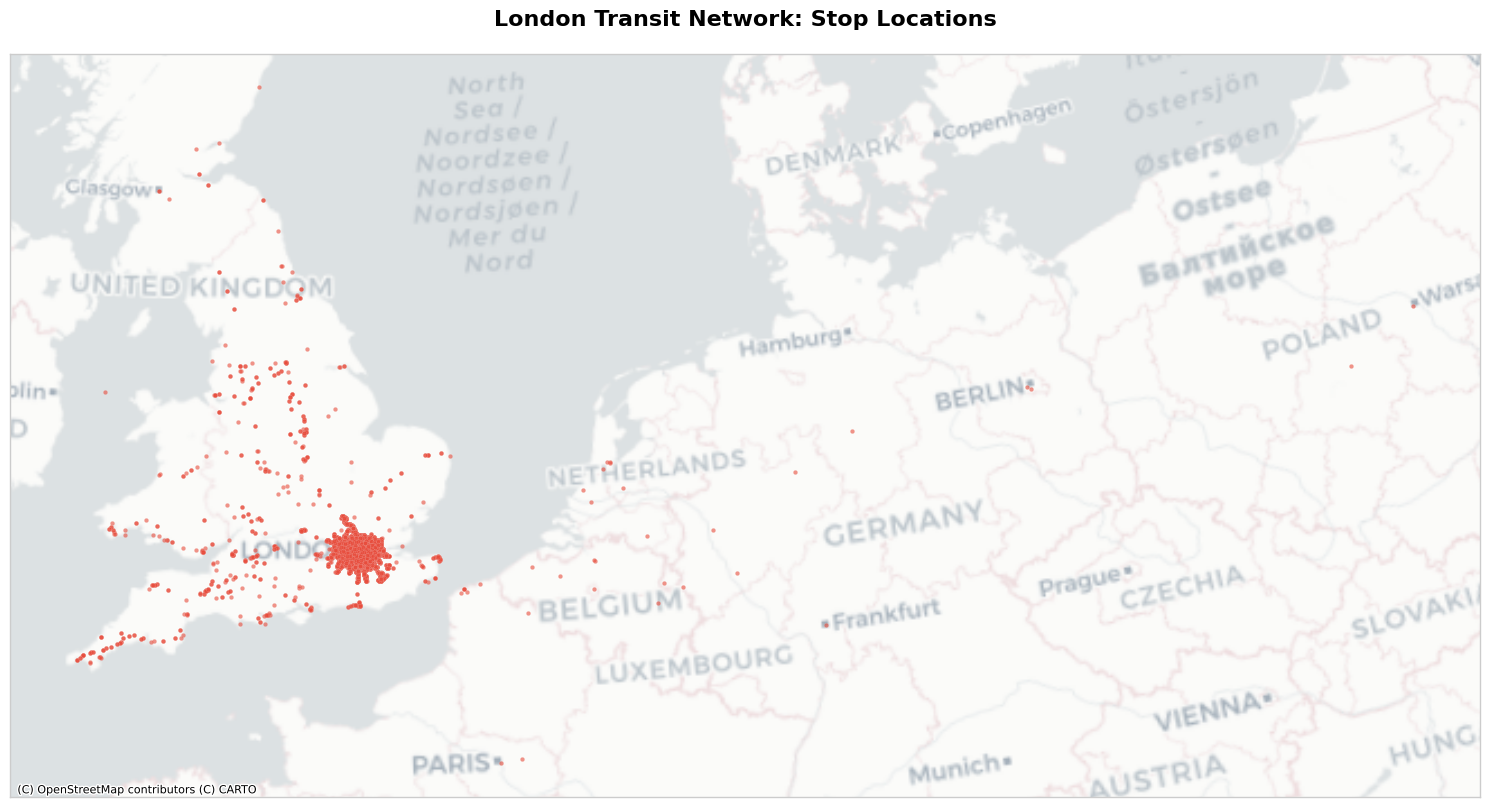

In [11]:
# Visualize the spatial distribution of transit stops
print("Visualizing London's Transit Network")
print("Creating a map showing the spatial distribution of all transit stops...")

# city2graph automatically provides stops as a GeoDataFrame - no conversion needed!
stops_gdf = gtfs_data['stops']

# Reproject to British National Grid for accurate distance calculations
stops_gdf_bng = stops_gdf.to_crs(epsg=27700)

# Create a professional-looking map
fig, ax = plt.subplots(figsize=(15, 12))

# Plot stops with transparency for overlapping points
stops_gdf_bng.plot(
    ax=ax, 
    alpha=0.6, 
    color='#e74c3c',  # Transport red
    markersize=10,
    edgecolors='white',
    linewidth=0.1
)

# Add contextual basemap
ctx.add_basemap(
    ax, 
    crs=stops_gdf_bng.crs.to_string(), 
    source=ctx.providers.CartoDB.Positron,
    alpha=0.8
)

# Clean up the map appearance
ax.set_title("London Transit Network: Stop Locations", fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

# Add a subtle border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_color('#cccccc')

ax.set_aspect('equal')
plt.tight_layout()

print(f"Mapped {len(stops_gdf):,} transit stops across Greater London")
plt.show()

## 3. Creating Transit Graphs with City2Graph

### The Power of Graph Representation
Raw GTFS data contains thousands of individual trips and stop times, but what we really want to understand are the **connections** and **flow patterns** in the network. This is where City2Graph shines - it transforms complex scheduling data into clean graph representations.

After loading the GTFS, `travel_summary_network` can summarise the trips between stops. The output contains the origin and destination of stops, with average travel times in seconds and frequency in the specified time intervals.

### travel_summary_graph: From Schedules to Networks

The `travel_summary_graph()` function is City2Graph's flagship feature for transportation analysis. It performs sophisticated aggregation:

**What it does:**
- Processes thousands of individual trips into meaningful connections between stops
- Calculates **average travel times** between consecutive stops
- Counts **service frequency** (how often services run between stop pairs)
- Creates **spatial geometries** for each connection
- Handles **complex scheduling** including service calendars and time-of-day filtering

**Why this matters:**
- Transforms scheduling complexity into simple origin-destination relationships
- Enables network analysis (shortest paths, centrality, accessibility)
- Perfect input for graph neural networks and machine learning
- Ready-to-use format for visualization and spatial analysis

Let's see this powerful transformation in action:

In [12]:
# Transform GTFS schedules into a travel network graph
print("Converting GTFS schedules to network representation...")
print("This processes thousands of trips into clean origin-destination relationships")

# The magic happens here - one function call does all the heavy lifting!
travel_summary_nodes, travel_summary_edges = city2graph.travel_summary_graph(
    gtfs_data, 
    calendar_start="20250601",  # Analyze services for June 1, 2025
    calendar_end="20250601"     # Single day analysis for demonstration
)

print("Network analysis complete!")
print(f"Created graph with:")
print(f"   • {len(travel_summary_nodes):,} nodes (stops with connections)")
print(f"   • {len(travel_summary_edges):,} edges (stop-to-stop connections)")
print(f"   • Each edge contains travel time and frequency data")

print("\nWhat city2graph calculated:")
print("   • Average travel time between each pair of connected stops")
print("   • Service frequency (trips per day) for each connection")
print("   • Spatial geometry for mapping and analysis")
print("   • Only includes stops that actually have transit service")

Converting GTFS schedules to network representation...
This processes thousands of trips into clean origin-destination relationships
Network analysis complete!
Created graph with:
   • 24,745 nodes (stops with connections)
   • 28,133 edges (stop-to-stop connections)
   • Each edge contains travel time and frequency data

What city2graph calculated:
   • Average travel time between each pair of connected stops
   • Service frequency (trips per day) for each connection
   • Spatial geometry for mapping and analysis
   • Only includes stops that actually have transit service
Network analysis complete!
Created graph with:
   • 24,745 nodes (stops with connections)
   • 28,133 edges (stop-to-stop connections)
   • Each edge contains travel time and frequency data

What city2graph calculated:
   • Average travel time between each pair of connected stops
   • Service frequency (trips per day) for each connection
   • Spatial geometry for mapping and analysis
   • Only includes stops that act

In [13]:
# Examine the nodes (stops) in our travel network
print("Network Nodes (Transit Stops):")
print("These are stops that have active transit connections")
print("Notice: Only stops with actual service are included in the network")

travel_summary_nodes.head()

Network Nodes (Transit Stops):
These are stops that have active transit connections
Notice: Only stops with actual service are included in the network


stop_code                       stop_name  stop_lat  stop_lon  \
stop_id                                                                     
490014597S      48536  White Hart Ln Grt Cambridge Rd  51.60490 -0.085950   
490007372S      74106                 Granville Place  51.59650 -0.387280   
490013521E      52358                  The Ravensbury  51.39799 -0.157870   
240G006160A       NaN                     Bus Station  51.27127  0.193303   
490007476V      56036     Palmers Green / Green Lanes  51.61252 -0.107100   

            wheelchair_boarding location_type parent_station platform_code  \
stop_id                                                                      
490014597S                    0             0            NaN           NaN   
490007372S                    0             0            NaN           NaN   
490013521E                    0             0            NaN           NaN   
240G006160A                   0             1            NaN           NaN   
490007476V                    0             0            NaN           NaN   

                              geometry  
stop_id                                 
490014597S    POINT (-0.08595 51.6049)  
490007372S    POINT (-0.38728 51.5965)  
490013521E   POINT (-0.15787 51.39799)  
240G006160A    POINT (0.1933 51.27127)  
490007476V    POINT (-0.1071 51.61252)

In [14]:
# Examine the edges (connections) in our travel network
print("Network Edges (Transit Connections):")
print("Each row represents a direct connection between two stops")
print("\nKey metrics city2graph calculated:")
print("   • mean_travel_time: Average time to travel between stops (seconds)")
print("   • frequency: Number of services per day on this connection")
print("   • geometry: LineString for mapping and spatial analysis")

print(f"\nPerformance insight:")
print(f"   Fastest connection: {travel_summary_edges['mean_travel_time'].min():.0f} seconds")
print(f"   Busiest connection: {travel_summary_edges['frequency'].max():.0f} services/day")
print(f"   Average travel time: {travel_summary_edges['mean_travel_time'].mean():.0f} seconds")

travel_summary_edges.head()

Network Edges (Transit Connections):
Each row represents a direct connection between two stops

Key metrics city2graph calculated:
   • mean_travel_time: Average time to travel between stops (seconds)
   • frequency: Number of services per day on this connection
   • geometry: LineString for mapping and spatial analysis

Performance insight:
   Fastest connection: 1 seconds
   Busiest connection: 999 services/day
   Average travel time: 436 seconds


mean_travel_time  frequency  \
from_stop_id to_stop_id                                  
01000053216  0170SGP90689        830.303030       99.0   
             0190NSZ01231       2700.000000        8.0   
             035059860001       5541.176471       17.0   
             1100DEA57098       6600.000000        6.0   
             360000174          3710.000000       30.0   

                                                                    geometry  
from_stop_id to_stop_id                                                       
01000053216  0170SGP90689  LINESTRING (-2.59298 51.45906, -2.54498 51.50353)  
             0190NSZ01231  LINESTRING (-2.59298 51.45906, -2.90907 51.36196)  
             035059860001  LINESTRING (-2.59298 51.45906, -0.98026 51.40611)  
             1100DEA57098  LINESTRING (-2.59298 51.45906, -3.52313 50.72689)  
             360000174     LINESTRING (-2.59298 51.45906, -3.06586 51.01774)

In [15]:
# Focus analysis on Greater London area using spatial filtering
print("Applying spatial filter to focus on Greater London...")
print("This demonstrates city2graph's seamless integration with geospatial analysis")

# Get London boundary using OSMnx
london_boundary = ox.geocode_to_gdf("Greater London, UK").to_crs(epsg=27700)

# Project our network data to British National Grid for accurate spatial operations
travel_summary_nodes = travel_summary_nodes.to_crs(epsg=27700)
travel_summary_edges = travel_summary_edges.to_crs(epsg=27700)

# Spatial join to filter data within London boundary
print("Filtering nodes and edges within London boundary...")
nodes_in_bound = gpd.sjoin(travel_summary_nodes, london_boundary, how="inner").drop(columns=['index_right'])
edges_in_bound = gpd.sjoin(travel_summary_edges, london_boundary, how="inner").drop(columns=['index_right'])

# Update variables and ensure edge consistency
travel_summary_nodes = nodes_in_bound
travel_summary_edges = edges_in_bound

# Keep only edges where both endpoints are in our filtered node set
travel_summary_edges = travel_summary_edges[
    travel_summary_edges.index.get_level_values('from_stop_id').isin(travel_summary_nodes.index) &
    travel_summary_edges.index.get_level_values('to_stop_id').isin(travel_summary_nodes.index)
]

print(f"Spatial filtering complete:")
print(f"   Nodes within London: {len(travel_summary_nodes):,}")
print(f"   Edges within London: {len(travel_summary_edges):,}")
print(f"   Data reduced by {((1 - len(travel_summary_nodes)/len(nodes_in_bound)) * 100):.1f}% for focused analysis")

Applying spatial filter to focus on Greater London...
This demonstrates city2graph's seamless integration with geospatial analysis
Filtering nodes and edges within London boundary...
Spatial filtering complete:
   Nodes within London: 20,220
   Edges within London: 25,182
   Data reduced by 0.0% for focused analysis
Spatial filtering complete:
   Nodes within London: 20,220
   Edges within London: 25,182
   Data reduced by 0.0% for focused analysis


Creating advanced network visualization...
This map shows the power of city2graph's transit network representation
Visualizing 20,600 transit connections
Features:
   • Line color: Travel time (darker = faster)
   • Line width: Service frequency (thicker = more frequent)
   • Geographic accuracy: Projected coordinate system
Network visualization complete!
Insights visible:
   • High-frequency corridors (thick lines)
   • Fast connections (dark lines)
   • Network density patterns across London
Network visualization complete!
Insights visible:
   • High-frequency corridors (thick lines)
   • Fast connections (dark lines)
   • Network density patterns across London


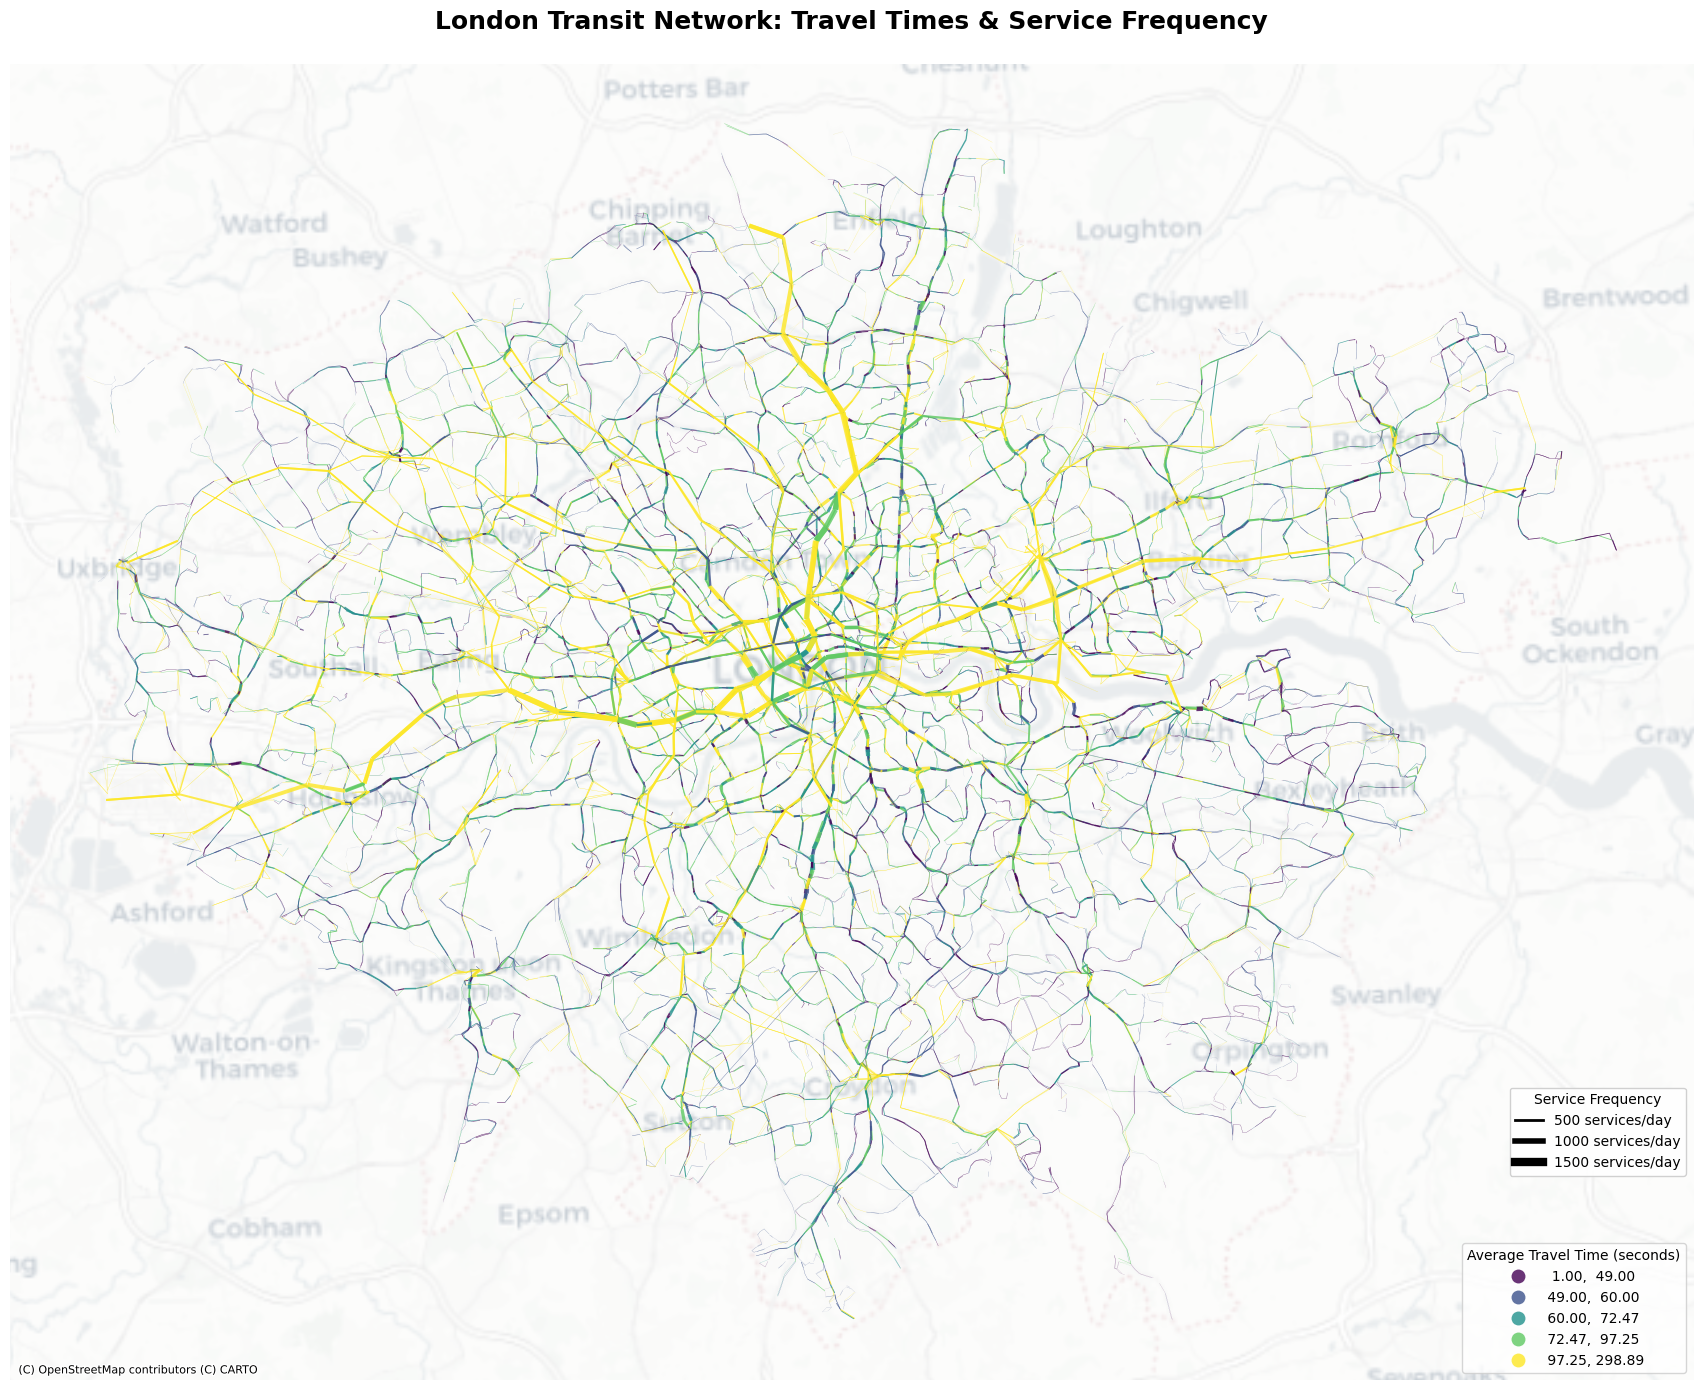

In [16]:
# Create a sophisticated network visualization
print("Creating advanced network visualization...")
print("This map shows the power of city2graph's transit network representation")

# Filter for reasonable travel times and prepare for visualization
edges_for_viz = edges_in_bound[edges_in_bound["mean_travel_time"] < 300]  # Under 5 minutes
edges_cropped = gpd.sjoin(
    edges_for_viz,
    london_boundary,
    how="inner",
    predicate="within"
)

print(f"Visualizing {len(edges_cropped):,} transit connections")
print("Features:")
print("   • Line color: Travel time (darker = faster)")
print("   • Line width: Service frequency (thicker = more frequent)")
print("   • Geographic accuracy: Projected coordinate system")

# Set up the visualization
cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(18, 14))

# Plot the network with dual encoding (color + width)
edges_cropped.plot(
    column="mean_travel_time",
    cmap=cmap,
    scheme="quantiles",
    k=5,
    linewidth=edges_cropped['frequency'] / 250,  # Frequency determines line width
    alpha=0.8,
    ax=ax,
    legend=True,
    legend_kwds={'title': 'Average Travel Time (seconds)', 'loc': 'lower right'}
)

# Customize the travel time legend
travel_time_legend = ax.get_legend()
travel_time_legend.set_bbox_to_anchor((1, 0))
travel_time_legend.set_loc('lower right')

# Add frequency legend
freq_values = [500, 1000, 1500]
freq_legend_elements = [
    mlines.Line2D([0], [0], color='black', linewidth=f/250, label=f'{f} services/day')
    for f in freq_values
]
freq_legend = ax.legend(
    handles=freq_legend_elements,
    title="Service Frequency",
    loc="lower right",
    bbox_to_anchor=(1, 0.15),
    frameon=True,
    framealpha=0.9
)
ax.add_artist(travel_time_legend)

# Add basemap for context
ctx.add_basemap(
    ax,
    crs=edges_cropped.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Professional styling
ax.set_title("London Transit Network: Travel Times & Service Frequency", 
             fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

# Clean border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('#333333')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

print("Network visualization complete!")
print("Insights visible:")
print("   • High-frequency corridors (thick lines)")
print("   • Fast connections (dark lines)")
print("   • Network density patterns across London")

plt.show()

## 4. Further Network Analysis with City2Graph

### Converting to NetworkX for Graph Algorithms

City2Graph seamlessly bridges the gap between geospatial data and network analysis. The `gdf_to_nx()` function converts our GeoDataFrames into NetworkX graphs, enabling powerful graph algorithms while preserving all spatial and transit-specific attributes.


In [17]:
# Convert to NetworkX graph for advanced network analysis
print("Converting to NetworkX for graph algorithms...")
travel_graph = city2graph.gdf_to_nx(travel_summary_nodes, travel_summary_edges)

print(f"NetworkX graph created:")
print(f"   • Nodes: {travel_graph.number_of_nodes():,}")
print(f"   • Edges: {travel_graph.number_of_edges():,}")
print(f"   • Graph type: {type(travel_graph).__name__}")

# Demonstrate city2graph's spatial filtering capabilities
print("\nApplying distance-based filtering...")
print("This showcases accessibility analysis - what's reachable within a distance?")

# Filter graph to show network within 1.2km of central London
central_london = london_boundary.geometry.iloc[0].centroid
filtered_travel_graph = city2graph.filter_graph_by_distance(
    travel_graph,
    center_point=central_london,
    distance=1200,  # 1.2 km radius
    edge_attr="mean_travel_time"  # Filter by travel time, not physical distance
)

print(f"Filtered network (1.2km from center):")
print(f"   • Nodes: {filtered_travel_graph.number_of_nodes():,}")
print(f"   • Edges: {filtered_travel_graph.number_of_edges():,}")
print(f"   • Reduction: {(1 - filtered_travel_graph.number_of_nodes()/travel_graph.number_of_nodes())*100:.1f}%")

# Convert back to GeoDataFrames for visualization
filtered_travel_nodes, filtered_travel_edges = city2graph.nx_to_gdf(filtered_travel_graph)

print("Ready for focused network analysis and visualization!")


Removed 3 invalid geometries


Converting to NetworkX for graph algorithms...
NetworkX graph created:
   • Nodes: 20,220
   • Edges: 25,139
   • Graph type: Graph

Applying distance-based filtering...
This showcases accessibility analysis - what's reachable within a distance?
Filtered network (1.2km from center):
   • Nodes: 714
   • Edges: 959
   • Reduction: 96.5%
Ready for focused network analysis and visualization!
NetworkX graph created:
   • Nodes: 20,220
   • Edges: 25,139
   • Graph type: Graph

Applying distance-based filtering...
This showcases accessibility analysis - what's reachable within a distance?
Filtered network (1.2km from center):
   • Nodes: 714
   • Edges: 959
   • Reduction: 96.5%
Ready for focused network analysis and visualization!


Creating focused network visualization for central London...
This demonstrates city2graph's ability to combine spatial and network analysis
Detailed network analysis complete!
Focused analysis shows:
   • 714 transit stops
   • 959 direct connections
   • Network connectivity patterns in central London
   • Service frequency and travel time relationships
Detailed network analysis complete!
Focused analysis shows:
   • 714 transit stops
   • 959 direct connections
   • Network connectivity patterns in central London
   • Service frequency and travel time relationships


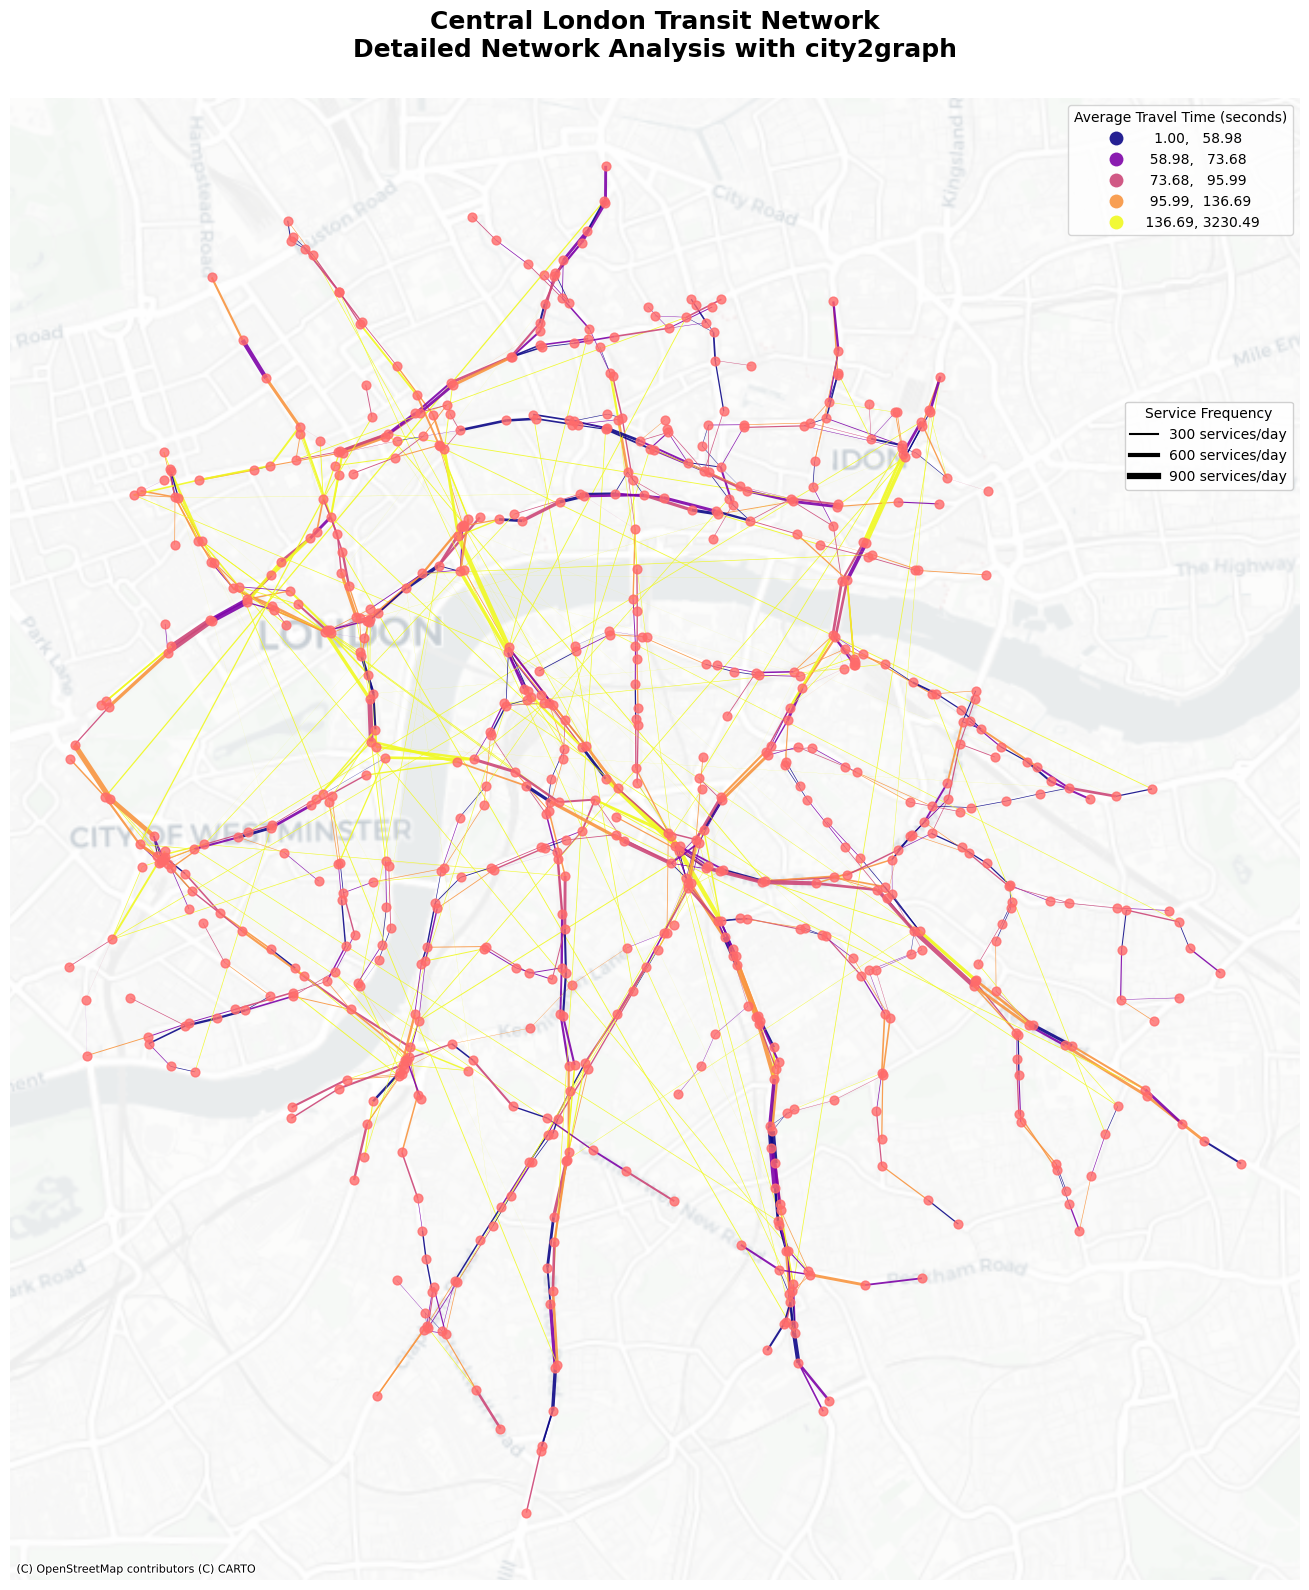

In [18]:
# Create a detailed view of central London's transit network
print("Creating focused network visualization for central London...")
print("This demonstrates city2graph's ability to combine spatial and network analysis")

# Set up the focused visualization
cmap = plt.cm.plasma
fig, ax = plt.subplots(figsize=(16, 16))

# Plot edges with enhanced styling
filtered_travel_edges.plot(
    column="mean_travel_time",
    cmap=cmap,
    scheme="quantiles",
    k=5,
    linewidth=filtered_travel_edges['frequency'] / 200,  # Adjusted for better visibility
    alpha=0.9,
    ax=ax,
    legend=True,
    legend_kwds={'title': 'Average Travel Time (seconds)', 'loc': 'upper right'}
)

# Highlight stops as network nodes
filtered_travel_nodes.plot(
    ax=ax, 
    color='#ff6b6b',  # Bright red for visibility
    markersize=40, 
    alpha=0.8, 
    zorder=3
)

# Customize legends
travel_time_legend = ax.get_legend()
travel_time_legend.set_bbox_to_anchor((1, 1))
travel_time_legend.set_loc('upper right')

# Service frequency legend
freq_values = [300, 600, 900]
freq_legend_elements = [
    mlines.Line2D([0], [0], color='black', linewidth=f/200, label=f'{f} services/day')
    for f in freq_values
]
freq_legend = ax.legend(
    handles=freq_legend_elements,
    title="Service Frequency",
    loc="upper right",
    bbox_to_anchor=(1, 0.8),
    frameon=True,
    framealpha=0.9
)
ax.add_artist(travel_time_legend)

# Add basemap for geographic context
ctx.add_basemap(
    ax,
    crs=edges_cropped.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Professional styling
ax.set_title("Central London Transit Network\nDetailed Network Analysis with city2graph", 
             fontsize=18, fontweight='bold', pad=30)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

# Clean border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('#2c3e50')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

print("Detailed network analysis complete!")
print(f"Focused analysis shows:")
print(f"   • {len(filtered_travel_nodes):,} transit stops")
print(f"   • {len(filtered_travel_edges):,} direct connections")
print(f"   • Network connectivity patterns in central London")
print(f"   • Service frequency and travel time relationships")

plt.show()

In [19]:
# Calculate betweenness centrality for the filtered_travel_graph
betweenness = nx.betweenness_centrality(filtered_travel_graph, weight='mean_travel_time', normalized=True)

nx.set_node_attributes(filtered_travel_graph, betweenness, "betweenness_centrality")

In [20]:
filtered_travel_nodes, filtered_travel_edges = city2graph.nx_to_gdf(filtered_travel_graph)

Creating focused network visualization for central London...
This demonstrates city2graph's ability to combine spatial and network analysis
Detailed network analysis complete!
Focused analysis shows:
   • 714 transit stops
   • 959 direct connections
   • Node color = betweenness centrality
   • Edge width = service frequency


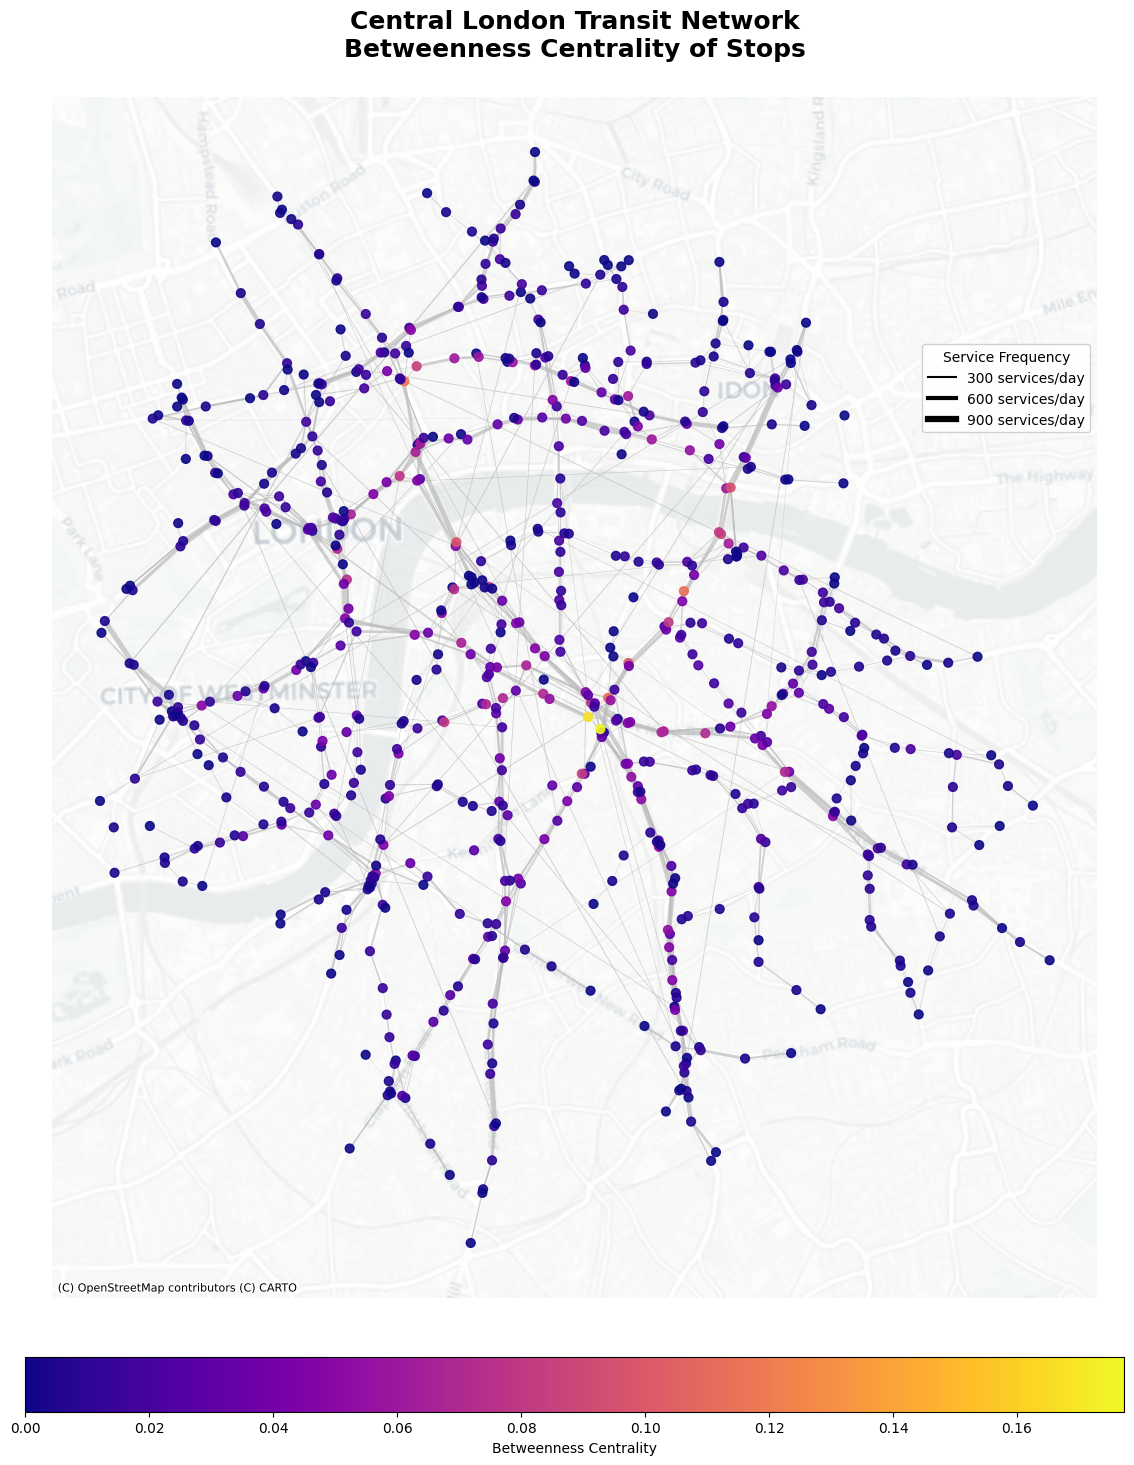

In [21]:
# Create a detailed view of central London's transit network
print("Creating focused network visualization for central London...")
print("This demonstrates city2graph's ability to combine spatial and network analysis")

fig, ax = plt.subplots(figsize=(16, 16))

# Plot edges in a neutral color (no color encoding)
filtered_travel_edges.plot(
    ax=ax,
    color="#bbbbbb",
    linewidth=filtered_travel_edges['frequency'] / 200,
    alpha=0.7,
    zorder=1
)

# Plot nodes colored by betweenness centrality, with horizontal colorbar at the bottom
filtered_travel_nodes.plot(
    ax=ax,
    column="betweenness_centrality",
    cmap="plasma",
    markersize=40,
    alpha=0.9,
    legend=True,
    legend_kwds={
        'orientation': 'horizontal',
        'shrink': 0.7,
        'pad': 0.04,
        'label': 'Betweenness Centrality'
    },
    zorder=2
)

# Service frequency legend for edges
freq_values = [300, 600, 900]
freq_legend_elements = [
    mlines.Line2D([0], [0], color='black', linewidth=f/200, label=f'{f} services/day')
    for f in freq_values
]
freq_legend = ax.legend(
    handles=freq_legend_elements,
    title="Service Frequency",
    loc="upper right",
    bbox_to_anchor=(1, 0.8),
    frameon=True,
    framealpha=0.9
)

# Add basemap for geographic context
ctx.add_basemap(
    ax,
    crs=filtered_travel_edges.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    alpha=0.5
)

# Professional styling
ax.set_title("Central London Transit Network\nBetweenness Centrality of Stops", 
             fontsize=18, fontweight='bold', pad=30)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])

# Clean border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_color('#2c3e50')

ax.set_aspect("equal")
ax.set_axis_off()
plt.tight_layout()

print("Detailed network analysis complete!")
print(f"Focused analysis shows:")
print(f"   • {len(filtered_travel_nodes):,} transit stops")
print(f"   • {len(filtered_travel_edges):,} direct connections")
print(f"   • Node color = betweenness centrality")
print(f"   • Edge width = service frequency")

plt.show()
